# **Lab 1**

## **Data Extraction**

In [35]:
# Setup
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings 
warnings.simplefilter(action = 'ignore')

import matplotlib
matplotlib.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": "Times New Roman"})

In [36]:
# Transform .dat file to .csv
for file in ["NACA0012_25Hz_70pitch", "NACA4412_25Hz_70pitch"]:
    datContent = []
    for i in open(file + ".dat").readlines():
        if str(i[0]) in ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "-"]:
            datContent.append(i.strip().split())

    with open(file + ".csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(datContent)

In [37]:
# Transform .csv to DataFrames

naca0012_data = {}
naca4412_data = {}

for file in ["NACA0012_25Hz_70pitch", "NACA4412_25Hz_70pitch"]:

    if file == "NACA0012_25Hz_70pitch":
        storage = naca0012_data
    elif file == "NACA4412_25Hz_70pitch":
        storage = naca4412_data

    df_composite = pd.read_csv(file + ".csv", index_col = 0, header = None, names = ["Dyn. Pressure (In. H20)", "Surf. Pressure (In. H20)"])

    # Break each airfoil's data into data for each AoA
    chunk_size = 19
    num_chunks = int(len(df_composite.index) / 19)

    for i in range(num_chunks):
        chunk_old = df_composite.iloc[chunk_size * i:chunk_size * (i+1)]
        chunk = chunk_old.iloc[1:, :]
        chunk.name = int(chunk_old.index[0])

        storage[chunk.name] = chunk

In [38]:
# Correcting pressure tap 17 for NACA4412

port_17 = pd.DataFrame(data = {'AoA': [0, 4, 6, 8, 10, 12, 14], 'Dynamic': [2.557, 2.614, 2.626, 2.644, 2.655, 2.654, 2.653], 'Static': [-0.193, 0.948, 1.117, 1.337, 1.451, 1.526, 1.580]})
i = 0
for item in naca4412_data:
    tbl = naca4412_data[item]
    tbl.loc[17][0] = port_17.iloc[i][1]
    tbl.loc[17][1] = port_17.iloc[i][2]
    naca4412_data[item] = tbl
    i += 1

In [39]:
# Plotting airfoil shape

#https://en.wikipedia.org/wiki/NACA_airfoil#Equation_for_a_cambered_4-digit_NACA_airfoil
def camber_line( x, m, p, c ):
    return np.where((x>=0)&(x<=(c*p)),
                    m * (x / np.power(p,2)) * (2.0 * p - (x / c)),
                    m * ((c - x) / np.power(1-p,2)) * (1.0 + (x / c) - 2.0 * p ))

def dyc_over_dx( x, m, p, c ):
    return np.where((x>=0)&(x<=(c*p)),
                    ((2.0 * m) / np.power(p,2)) * (p - x / c),
                    ((2.0 * m ) / np.power(1-p,2)) * (p - x / c ))

def thickness( x, t, c ):
    term1 =  0.2969 * (np.sqrt(x/c))
    term2 = -0.1260 * (x/c)
    term3 = -0.3516 * np.power(x/c,2)
    term4 =  0.2843 * np.power(x/c,3)
    term5 = -0.1015 * np.power(x/c,4)
    return 5 * t * c * (term1 + term2 + term3 + term4 + term5)

def naca4(x, m, p, t, c=1):
    dyc_dx = dyc_over_dx(x, m, p, c)
    th = np.arctan(dyc_dx)
    yt = thickness(x, t, c)
    yc = camber_line(x, m, p, c)  
    return ((x - yt*np.sin(th), yc + yt*np.cos(th)), 
            (x + yt*np.sin(th), yc - yt*np.cos(th)))

In [40]:
# Airfoil pressure tap geometry

naca0012_shape = pd.DataFrame(data = {
    'Tap': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
    'X Chord %': [0, 3.5, 8.8, 14.0, 19.3, 24.6, 29.8, 35.1, 40.4, 45.6, 50.9, 56.2, 61.4, 66.7, 72.0, 77.2, 82.5, 87.8],
    'Y Chord %': [0, 3.0, 4.5, 5.2, 5.7, 5.9, 6.0, 5.9, 5.8, 5.5, 5.2, 4.9, 4.4, 4.0, 3.5, 2.9, 2.3, 1.7]
})

naca4412_shape = pd.DataFrame(data = {
    'Tap': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
    'X Chord %': [0, 2.5, 5, 10, 20, 30, 40, 50, 70, 90, 85.8, 70, 50, 30, 20, 10, 6, 4], 
    'Y Chord %': [0, 3.4, 4.7, 6.6, 8.8, 9.8, 9.8, 9.2, 6.7, 2.7, -.3, -.7, -1.4, -2.3, -2.7, -2.9, -2.6, -2.3]
})

## **Task 1**

In [41]:
# Calculating U, Re, Cp

U_naca0012 = 33.3 # m/s
U_naca4412 = 34.0 # m/s

chord = .1524 # m [6 in]

p_atm = 98700 # Pa [29.15 in Hg]
T_atm = 300.93 # K [82 F, 27.78 C]
rho = 1.14486 # kg/m3 [at given p_atm and t_atm]
mu = 18.5 * 10**-6 # Pa*s

re_naca0012 = rho * U_naca0012 * chord / mu
re_naca4412 = rho * U_naca4412 * chord / mu

# Exporting all dataframes to single Excel sheet
writer = pd.ExcelWriter("Cp_Data.xlsx", engine = "xlsxwriter")
workbook=writer.book

Q = 0
for item in naca0012_data:
    tbl = naca0012_data[item]
    tbl["Cp"] = ((pd.to_numeric(tbl["Surf. Pressure (In. H20)"]))) / (pd.to_numeric(tbl["Dyn. Pressure (In. H20)"]))
    tbl["U"] = (2 * (pd.to_numeric(tbl["Dyn. Pressure (In. H20)"]) * 249.08) / rho) ** .5
    tbl["AoA"] = item
    naca0012_data[item] = tbl
    tbl.to_excel(writer, sheet_name='NACA0012', startrow=0 , startcol=(6*Q), index = False)
    Q += 1

Q = 0
for item in naca4412_data:
    tbl = naca4412_data[item]
    tbl["Cp"] = ((pd.to_numeric(tbl["Surf. Pressure (In. H20)"]))) / (pd.to_numeric(tbl["Dyn. Pressure (In. H20)"]))
    tbl["U"] = (2 * (pd.to_numeric(tbl["Dyn. Pressure (In. H20)"]) * 249.08) / rho) ** .5
    tbl["AoA"] = item
    naca4412_data[item] = tbl
    tbl.to_excel(writer, sheet_name='NACA4412', startrow=0 , startcol=(6*Q), index = False)
    Q += 1

writer.close()
workbook.close()

## **Task 2**

#### **2B**

In [42]:
# NACA 0012 Cp plotting function

def symmetrical_pressure_plot(i):

    if i == 0:
        j = 0
    else: j = -i

    fig, ax = plt.subplots(figsize = (10, 10))
    fig.patch.set_facecolor('white')

    ax2 = ax.twinx()
    x = np.linspace(0,100,200)
    for item in naca4(x, 00, .00000001, .12, 100):
        ax2.plot(item[0], item[1], 'k')

    ax.set_ylim([max(naca0012_data[i]["Cp"].abs().max(axis = 0), naca0012_data[j]["Cp"].abs().max(axis = 0)) * -1.25, max(naca0012_data[i]["Cp"].abs().max(axis = 0), naca0012_data[j]["Cp"].abs().max(axis = 0)) * 1.25])
    ax.set_ylim(ax.get_ylim()[::-1])
    ax2.set_ylim([-50, 50])
    # ax2.plot(naca0012_shape["X Chord %"], naca0012_shape["Y Chord %"], 'mo', markersize = 5)
    ax2.get_yaxis().set_visible(False)
    ax.plot(naca0012_shape["X Chord %"], naca0012_data[i]["Cp"], 'b')
    ax.plot(naca0012_shape["X Chord %"], naca0012_data[j]["Cp"], 'b')
    ax.set_xlabel('Chord Percentage', fontsize = 16, fontweight = 'bold')
    ax.set_ylabel(r'$C_p$', fontsize = 16, fontweight = "bold")
    plt.title(rf"{i}$^\circ$ AoA - NACA 0012", fontsize = 20, fontweight = 'bold')
    plt.xlim((-1, 101))
    ax.spines[['right', 'top']].set_visible(False)
    ax2.spines[['right', 'top']].set_visible(False)
    return plt

In [43]:
# NACA 4412 Cp plotting function

def cambered_pressure_plot(i):
    fig, ax = plt.subplots(figsize = (10, 10))
    fig.patch.set_facecolor('white')

    ax2 = ax.twinx()
    x = np.linspace(0,100,200)
    for item in naca4(x, .04, .4, .12, 100):
        ax2.plot(item[0], item[1], 'k')

    ax.set_ylim([naca4412_data[i]["Cp"].abs().max(axis = 0) * -1.25, naca4412_data[i]["Cp"].abs().max(axis = 0) * 1.25])
    ax.set_ylim(ax.get_ylim()[::-1])
    ax2.set_ylim([-50, 50])
    # ax2.plot(naca4412_shape["X Chord %"], naca4412_shape["Y Chord %"], 'mo', markersize = 5)
    ax2.get_yaxis().set_visible(False)
    ax.plot(naca4412_shape["X Chord %"], naca4412_data[i]["Cp"], 'b')
    ax.set_xlabel('Chord Percentage', fontsize = 16, fontweight = 'bold')
    ax.set_ylabel(r'$C_p$', fontsize = 16, fontweight = "bold")
    plt.title(rf"{i}$^\circ$ AoA - NACA 4412", fontsize = 20, fontweight = 'bold')
    plt.xlim((-1, 101))
    ax.spines[['right', 'top']].set_visible(False)
    ax2.spines[['right', 'top']].set_visible(False)
    return plt

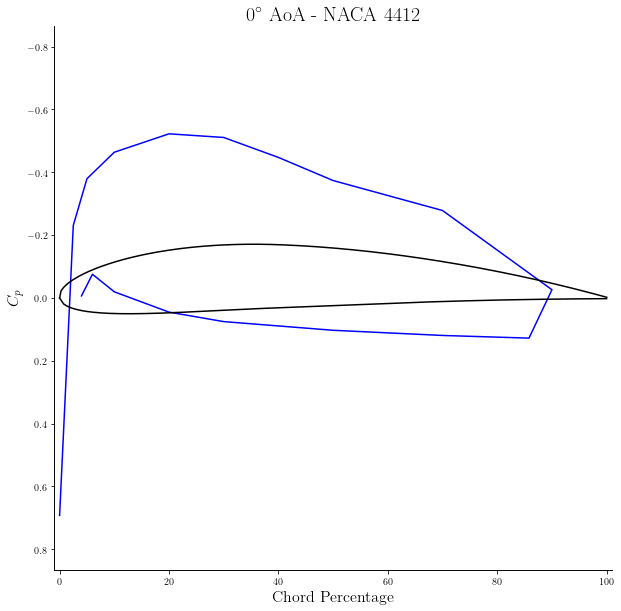

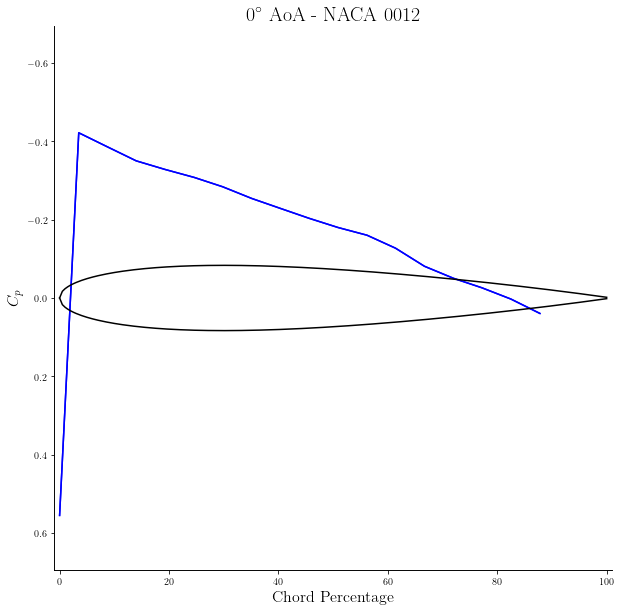

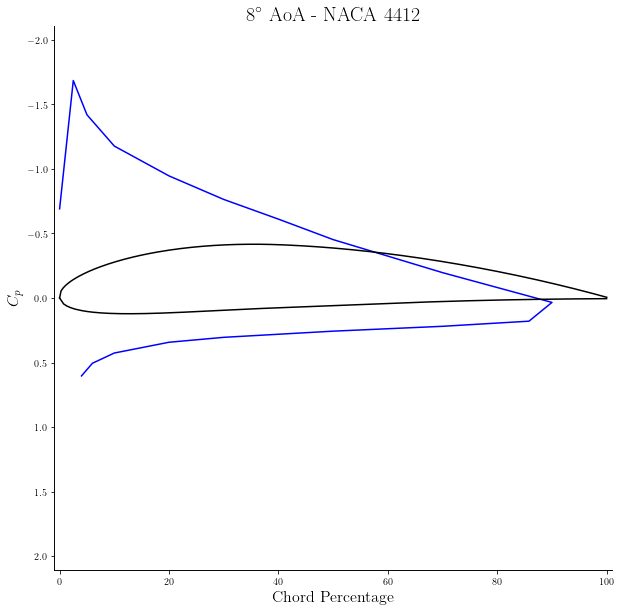

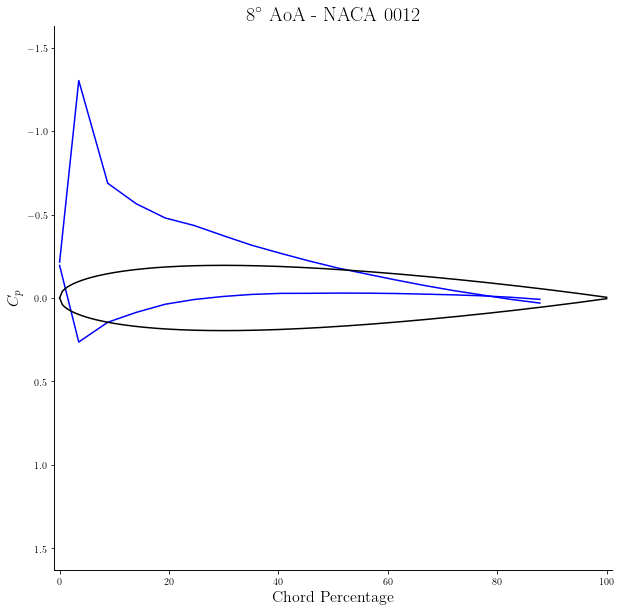

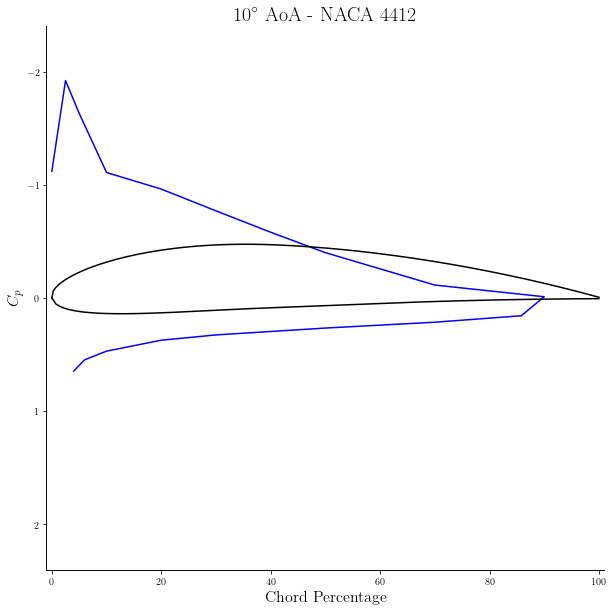

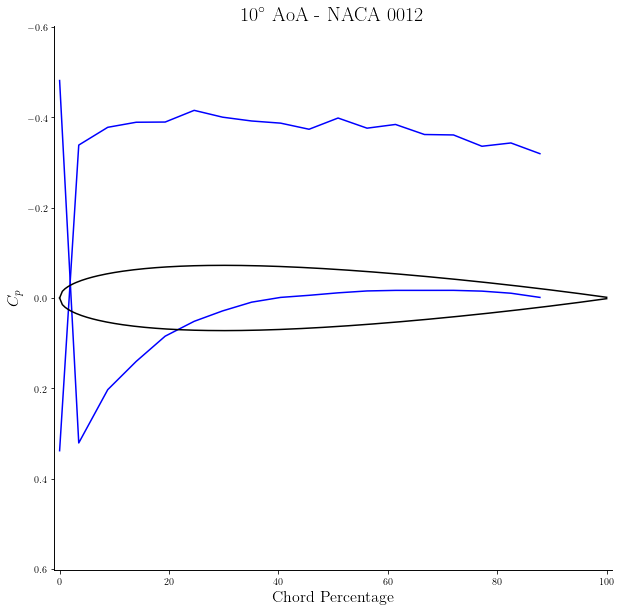

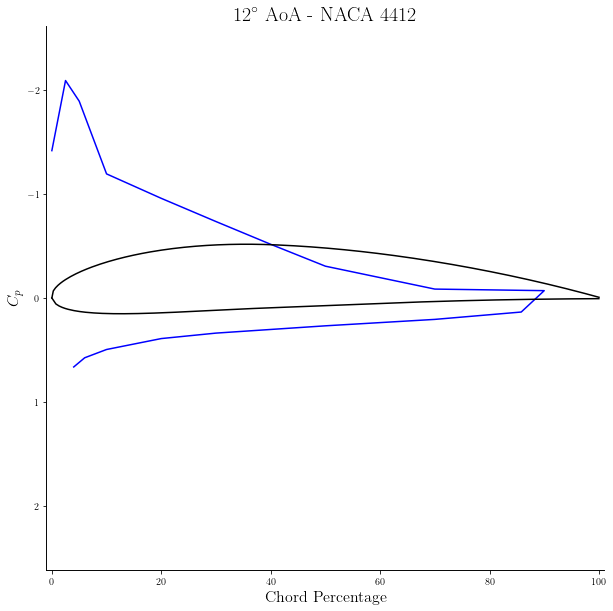

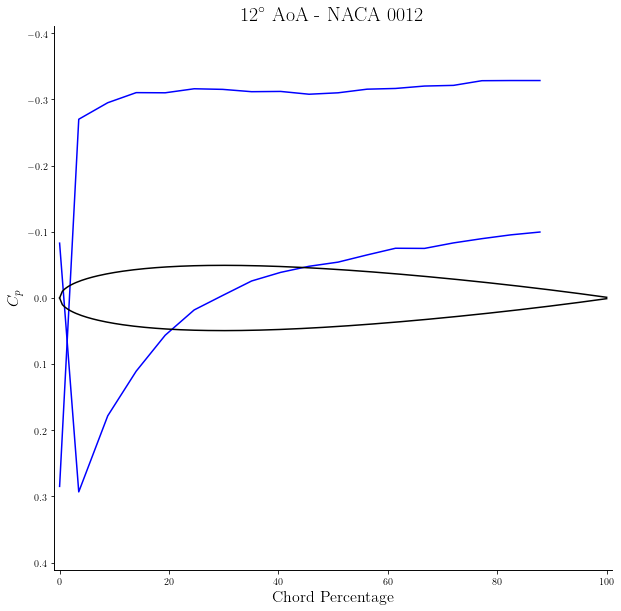

In [44]:
# Iterate through each AoA and save the figures to respective folders

for i in [0, 8, 10, 12]:
    cambered_pressure_plot(i).savefig(f'naca4412_Cp/4412_{i}_AoA_Cp.png')
    symmetrical_pressure_plot(i).savefig(f'naca0012_Cp/0012_{i}_AoA_Cp.png')


#### **2A**

In [148]:
# # Finds the angle (rad) of the normal line at each pressure tap
# def normal_line(m,p,x):
#     if x <= p:
#         derivative = (2*m/(p**2))*(p-x)
#     elif (p <= x) & (x <= 1):
#         derivative = (2*m/((1-p)**2))*(p-x)

#     if derivative == 0:
#         normal = -.000001
#     else:
#         normal = -1/derivative
        
#     angle = np.arctan(normal)
#     return angle, normal, derivative
# Creates a vector for each pressure port

# vectors = []
# for i in range(len(naca4412_shape["X Chord %"])):
#     angle = normal_line(.04, .4, float(naca4412_shape["X Chord %"][i]) / 100)
#     magnitude = naca4412_data[8]["Cp"][i+1]
#     origin_x = float(naca4412_shape["X Chord %"][i])
#     origin_y = float(naca4412_shape["Y Chord %"][i])
#     x_component = magnitude * np.cos(angle)
#     y_component = magnitude * np.sin(angle)
#     vectors.append([origin_x, origin_y, x_component, y_component])

# # Plotting vectors against airfoil geometry
# fig, ax = plt.subplots(figsize = (10, 10))
# fig.patch.set_facecolor('white')

# ax2 = ax.twinx()
# x = np.linspace(0,100,200)
# for item in naca4(x, .04, .4, .12, 100):
#     ax2.plot(item[0], item[1], 'k')

# ax.set_ylim([naca4412_data[8]["Cp"].abs().max(axis = 0) * -1.25, naca4412_data[14]["Cp"].abs().max(axis = 0) * 1.25])
# ax.set_ylim(ax.get_ylim()[::-1])
# ax2.set_ylim([-50, 50])
# ax2.plot(naca4412_shape["X Chord %"], naca4412_shape["Y Chord %"], 'mo', markersize = 5)
# ax2.get_yaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)

# # Plot each vector
# for i in range(len(vectors)):
#     ax2.quiver(vectors[i][0], vectors[i][1], vectors[i][2], vectors[i][3], angles='xy', scale_units='xy', scale=.05, color='r')

# ax.set_xlabel('Chord Percentage', fontsize = 16, fontweight = 'bold')
# plt.title(rf"8$^\circ$ AoA - NACA 4412", fontsize = 20, fontweight = 'bold')
# plt.xlim((-25, 125))
# ax.spines[['right', 'top', 'left']].set_visible(False)
# ax2.spines[['right', 'top', 'left']].set_visible(False)


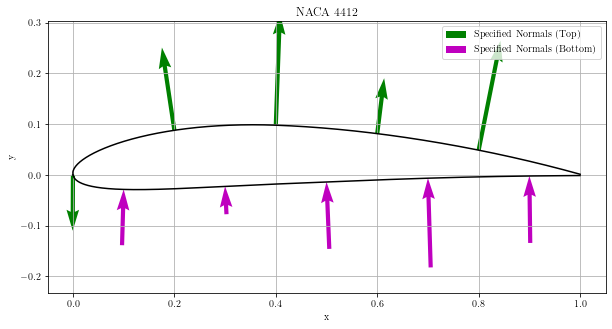

In [222]:
# Define your NACA airfoil parameters
m = 0.04  # Maximum camber
p = 0.4   # Location of maximum camber
t = 0.12  # Thickness
c = 1.0   # Chord length

# Generate x-coordinates
x = np.linspace(0, 1, 1000)

# Calculate airfoil coordinates
x_upper, x_lower, y_upper, y_lower = naca4(x, m, p, t, c)

# Specify the x-coordinates for the vectors on the upper and lower surfaces separately
vector_x_coordinates_upper = [0.0, 0.2, 0.4, 0.6, 0.8]  # Specify x-coordinates for upper surface vectors
vector_x_coordinates_lower = [0.1, 0.3, 0.5, 0.7, 0.9]  # Specify x-coordinates for lower surface vectors
vector_magnitudes_upper = [0.1, 0.15, 0.2, 0.1, 0.2]  # Specify the magnitudes of the vectors
vector_magnitudes_lower = [0.1, 0.05, 0.12, 0.16, 0.12]  # Specify the magnitudes of the vectors

# Function to calculate the local normal vectors at specified x-coordinates for both surfaces
def calculate_specified_normals(x, y, vector_x_coordinates, vector_magnitudes):
    normals_x = []
    normals_y = []
    for xi, magnitude in zip(vector_x_coordinates, vector_magnitudes):
        idx = np.argmin(np.abs(x - xi))
        dx = x[idx + 1] - x[idx - 1]
        dy = y[idx + 1] - y[idx - 1]
        normal_length = np.sqrt(dx ** 2 + dy ** 2)
        
        normals_x.append(-dy / normal_length * magnitude)
        normals_y.append(dx / normal_length * magnitude)
    return normals_x, normals_y

# Calculate normal vectors for both surfaces at specified x-coordinates
normals_x_upper, normals_y_upper = calculate_specified_normals(x_upper, y_upper, vector_x_coordinates_upper, vector_magnitudes_upper)
normals_x_lower, normals_y_lower = calculate_specified_normals(x_lower, y_lower, vector_x_coordinates_lower, vector_magnitudes_lower)

# Plot the airfoil
plt.figure(figsize=(10, 5))
plt.plot(x_upper, y_upper, 'k-')
plt.plot(x_lower, y_lower, 'k-')

# Plot specified normal vectors on the upper surface with arrow tips touching
plt.quiver(vector_x_coordinates_upper, [y_upper[np.argmin(np.abs(x_upper - xi))] for xi in vector_x_coordinates_upper],
           normals_x_upper, normals_y_upper, scale=1, color='g', label='Specified Normals (Top)', pivot='tail')
# Plot specified normal vectors on the lower surface with arrow tips touching
plt.quiver(vector_x_coordinates_lower, [y_lower[np.argmin(np.abs(x_lower - xi))] for xi in vector_x_coordinates_lower],
           normals_x_lower, normals_y_lower, scale=1, color='m', label='Specified Normals (Bottom)', pivot='tip')

plt.xlabel('x')
plt.ylabel('y')
plt.title('NACA 4412')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


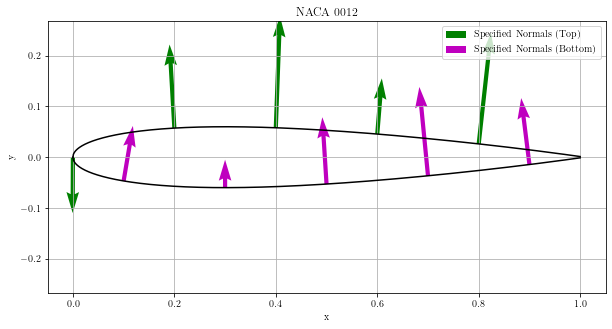

In [221]:
# Define your NACA airfoil parameters
m = 0.0    # Maximum camber
p = 0.00001    # Location of maximum camber
t = 0.12   # Thickness
c = 1.0    # Chord length

# Generate x-coordinates
x = np.linspace(0, 1, 1000)

# Calculate airfoil coordinates for NACA 0012
x_upper, x_lower, y_upper, y_lower = naca4(x, m, p, t, c)

# Specify the x-coordinates for the vectors on the upper and lower surfaces separately
vector_x_coordinates_upper = [0.0, 0.2, 0.4, 0.6, 0.8]  # Specify x-coordinates for upper surface vectors
vector_x_coordinates_lower = [0.1, 0.3, 0.5, 0.7, 0.9]  # Specify x-coordinates for lower surface vectors
vector_magnitudes_upper = [0.1, 0.15, 0.2, 0.1, 0.2]  # Specify the magnitudes of the vectors
vector_magnitudes_lower = [0.1, 0.05, 0.12, 0.16, 0.12]  # Specify the magnitudes of the vectors

# Function to calculate the local normal vectors at specified x-coordinates for both surfaces
def calculate_specified_normals(x, y, vector_x_coordinates, vector_magnitudes):
    normals_x = []
    normals_y = []
    for xi, magnitude in zip(vector_x_coordinates, vector_magnitudes):
        idx = np.argmin(np.abs(x - xi))
        dx = x[idx + 1] - x[idx - 1]
        dy = y[idx + 1] - y[idx - 1]
        normal_length = np.sqrt(dx ** 2 + dy ** 2)
        
        normals_x.append(-dy / normal_length * magnitude)
        normals_y.append(dx / normal_length * magnitude)
    return normals_x, normals_y

# Calculate normal vectors for both surfaces at specified x-coordinates
normals_x_upper, normals_y_upper = calculate_specified_normals(x_upper, y_upper, vector_x_coordinates_upper, vector_magnitudes_upper)
normals_x_lower, normals_y_lower = calculate_specified_normals(x_lower, y_lower, vector_x_coordinates_lower, vector_magnitudes_lower)

# Plot the airfoil
plt.figure(figsize=(10, 5))
plt.plot(x_upper, y_upper, 'k-')
plt.plot(x_lower, y_lower, 'k-')

# Plot specified normal vectors on the upper surface with arrow tips touching
plt.quiver(vector_x_coordinates_upper, [y_upper[np.argmin(np.abs(x_upper - xi))] for xi in vector_x_coordinates_upper],
           normals_x_upper, normals_y_upper, scale=1, color='g', label='Specified Normals (Top)', pivot='tail')
# Plot specified normal vectors on the lower surface with arrow tips touching
plt.quiver(vector_x_coordinates_lower, [y_lower[np.argmin(np.abs(x_lower - xi))] for xi in vector_x_coordinates_lower],
           normals_x_lower, normals_y_lower, scale=1, color='m', label='Specified Normals (Bottom)', pivot='tail')

plt.xlabel('x')
plt.ylabel('y')
plt.title('NACA 0012')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


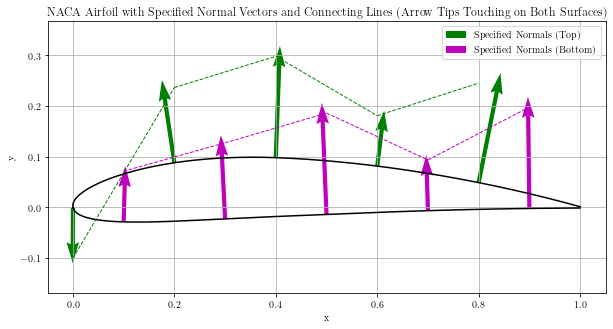

In [207]:
import numpy as np
import matplotlib.pyplot as plt

# Define your NACA airfoil parameters
m = 0.04  # Maximum camber
p = 0.4   # Location of maximum camber
t = 0.12  # Thickness
c = 1.0   # Chord length

# Generate x-coordinates
x = np.linspace(0, 1, 1000)

# Calculate airfoil coordinates
x_upper, x_lower, y_upper, y_lower = naca4(x, m, p, t, c)

# Specify the x-coordinates for the vectors on the upper and lower surfaces separately
vector_x_coordinates_upper = [0.0, 0.2, 0.4, 0.6, 0.8]  # Specify x-coordinates for upper surface vectors
vector_x_coordinates_lower = [0.1, 0.3, 0.5, 0.7, 0.9]  # Specify x-coordinates for lower surface vectors
vector_magnitudes = [0.1, 0.15, 0.2, 0.1, 0.2]  # Specify the magnitudes of the vectors

# Function to calculate the local normal vectors at specified x-coordinates for both surfaces
def calculate_specified_normals(x, y, vector_x_coordinates, vector_magnitudes):
    normals_x = []
    normals_y = []
    for xi, magnitude in zip(vector_x_coordinates, vector_magnitudes):
        idx = np.argmin(np.abs(x - xi))
        dx = x[idx + 1] - x[idx - 1]
        dy = y[idx + 1] - y[idx - 1]
        normal_length = np.sqrt(dx ** 2 + dy ** 2)
        
        normals_x.append(-dy / normal_length * magnitude)
        normals_y.append(dx / normal_length * magnitude)
    return normals_x, normals_y

# Calculate normal vectors for both surfaces at specified x-coordinates
normals_x_upper, normals_y_upper = calculate_specified_normals(x_upper, y_upper, vector_x_coordinates_upper, vector_magnitudes)
normals_x_lower, normals_y_lower = calculate_specified_normals(x_lower, y_lower, vector_x_coordinates_lower, vector_magnitudes)

# Plot the airfoil
plt.figure(figsize=(10, 5))
plt.plot(x_upper, y_upper, 'k-')
plt.plot(x_lower, y_lower, 'k-')

# Plot specified normal vectors on the upper surface with arrow tips touching
plt.quiver(vector_x_coordinates_upper, [y_upper[np.argmin(np.abs(x_upper - xi))] for xi in vector_x_coordinates_upper],
           normals_x_upper, normals_y_upper, scale=1, color='g', label='Specified Normals (Top)', pivot='tail')
# Plot specified normal vectors on the lower surface with arrow tips touching
plt.quiver(vector_x_coordinates_lower, [y_lower[np.argmin(np.abs(x_lower - xi))] for xi in vector_x_coordinates_lower],
           normals_x_lower, normals_y_lower, scale=1, color='m', label='Specified Normals (Bottom)', pivot='tail')

# Add lines connecting the arrow tips on the top and bottom surfaces
for i in range(len(vector_x_coordinates_upper) - 1):
    plt.plot([vector_x_coordinates_upper[i], vector_x_coordinates_upper[i + 1]],
             [y_upper[np.argmin(np.abs(x_upper - vector_x_coordinates_upper[i]))] + normals_y_upper[i],
              y_upper[np.argmin(np.abs(x_upper - vector_x_coordinates_upper[i + 1]))] + normals_y_upper[i + 1]], 'g--', lw=1)
    plt.plot([vector_x_coordinates_lower[i], vector_x_coordinates_lower[i + 1]],
             [y_lower[np.argmin(np.abs(x_lower - vector_x_coordinates_lower[i]))] + normals_y_lower[i],
              y_lower[np.argmin(np.abs(x_lower - vector_x_coordinates_lower[i + 1]))] + normals_y_lower[i + 1]], 'm--', lw=1)

plt.xlabel('x')
plt.ylabel('y')
plt.title('NACA Airfoil with Specified Normal Vectors and Connecting Lines (Arrow Tips Touching on Both Surfaces)')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()
